**1 задание**

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?

Схема базы данных
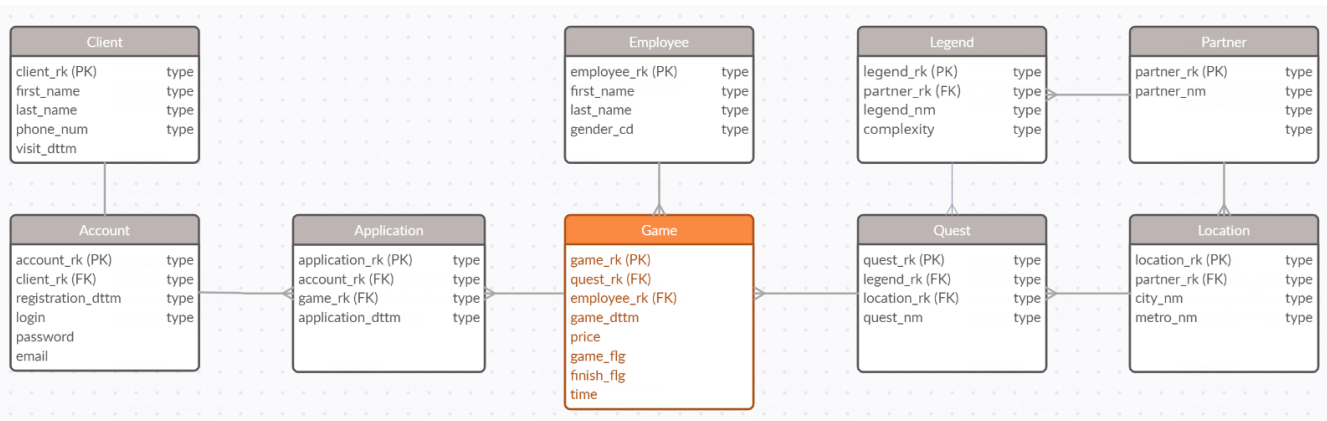

Подключение библиотек

In [ ]:
import psycopg2
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
from matplotlib import pyplot as plt

Подключение к базе

In [ ]:
conn = psycopg2.connect(
 host="158.160.52.106",
 port=5432,
 database="postgres",
 user="student",
 password="JvLda93aA",
)
cur = conn.cursor()

# Данные за все время

Сначала с помощью sql-запросов выберу нужные данные за все время наблюдений. 

Просмотры - все люди, зашедшие на сайт.

Регистрации - все люди, зарегистрировавшиеся на сайте.

Заявки - все уникальные люди, которые подали хотя бы 1 заявку. (нужны именно уникальные, так как любой человек мог подать несколько заявок)

Игры - все уникальные люди, у которых есть зарегистрированный аккаунт, и которые пришли хотя бы на одну состоявшуюся игру. (нужны именно уникальные, так как любой человек мог посетить несколько состоявшихся игр)

In [ ]:
views = pd.read_sql("SELECT COUNT(DISTINCT client_rk) AS views FROM msu_analytics.client", conn)
registrations = pd.read_sql("SELECT COUNT(DISTINCT account_rk) AS registrations FROM msu_analytics.account", conn)
applications = pd.read_sql("SELECT COUNT(DISTINCT account_rk) AS applications FROM msu_analytics.application", conn)
games_visited= df3=pd.read_sql(f"""SELECT COUNT(DISTINCT account_rk) AS games_visited
FROM msu_analytics.application INNER JOIN msu_analytics.game
ON application.game_rk=game.game_rk
WHERE game.game_flg = 1""", conn)
all_data = views.join([registrations, applications, games_visited])

In [ ]:
all_data.sum()

views            4096
registrations    1024
applications      293
games_visited     198
dtype: int64

Получились следующие данные - на сайт зашли 4096 человек, зарегистрировались 1024, подали заявку 293 человека, а явились на игру всего 198. Далее необходимо построить конверсионную воронку. 

Conversion funnel описывает изменение количества посетителей на сайте, когда они проходят все стадии преобразования из обычных посетителей в покупателей товара или услуги. 

**При наведении курсора на график, можно увидеть конверсию относительно общего числа (% of initial) и предыдущего этапа (% of previous). Если воронку не видно, перезапустите, пожалуйста, ячейку.**

In [ ]:
fig = go.Figure(go.Funnel(
    y = ["Посетили сайт", "Зарегистрировались", "Оставили заявку на игру", "Пришли на игру"],
    x = all_data.sum(),
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.update_layout(
    title=dict(text="Конверсионная воронка (данные за все время наблюдений)", font=dict(size=20), yref='paper')
)

fig.show()

# Данные по неделям

Далее с помощью sql-запросов выберу нужные данные, сгруппированные и отсортированные по неделям.

Функция DATE_TRUNC округляет дату до первого для недели.

In [ ]:
columns_123 = pd.read_sql("""SELECT DATE_TRUNC('week', visit_dttm)::date AS weeks, 
            COUNT(DISTINCT c.client_rk) AS views, 
            COUNT(DISTINCT a.account_rk) AS registrations, 
            COUNT(DISTINCT ap.account_rk) AS applications 
            FROM msu_analytics.client c 
            LEFT JOIN msu_analytics.account a using (client_rk) 
            LEFT JOIN msu_analytics.application ap using (account_rk)
            GROUP BY weeks
            ORDER BY weeks""", conn)

column_4 = pd.read_sql("""SELECT DATE_TRUNC('week', client.visit_dttm)::date AS weeks, 
            COUNT(DISTINCT account_rk) AS games_visited
            FROM msu_analytics.client 
            inner join msu_analytics.account using (client_rk)
            inner join msu_analytics.application using (account_rk ) 
            INNER JOIN msu_analytics.game using (game_rk)
            WHERE game.game_flg = 1
            group by weeks
            order by weeks""", conn)

In [ ]:
weeks_all_data = columns_123.merge(column_4, on="weeks", how="left")

In [ ]:
weeks_all_data

,weeks,views,registrations,applications,games_visited
0,2022-08-29,111,32,7,5.0
1,2022-09-05,184,31,6,5.0
2,2022-09-12,167,43,16,8.0
3,2022-09-19,181,45,12,11.0
4,2022-09-26,195,59,17,17.0
5,2022-10-03,204,58,18,15.0
6,2022-10-10,190,44,13,13.0
7,2022-10-17,171,41,12,10.0
8,2022-10-24,189,48,15,11.0
9,2022-10-31,197,47,16,14.0


Для дальнейшего изображения на графике необходимо посчитать конверсии относительно посетивших сайт

In [ ]:
percent_registr = weeks_all_data["registrations"]/weeks_all_data["views"]*100
percent_applic = weeks_all_data["applications"]/weeks_all_data["views"]*100
percent_visit_game = weeks_all_data["games_visited"]/weeks_all_data["views"]*100

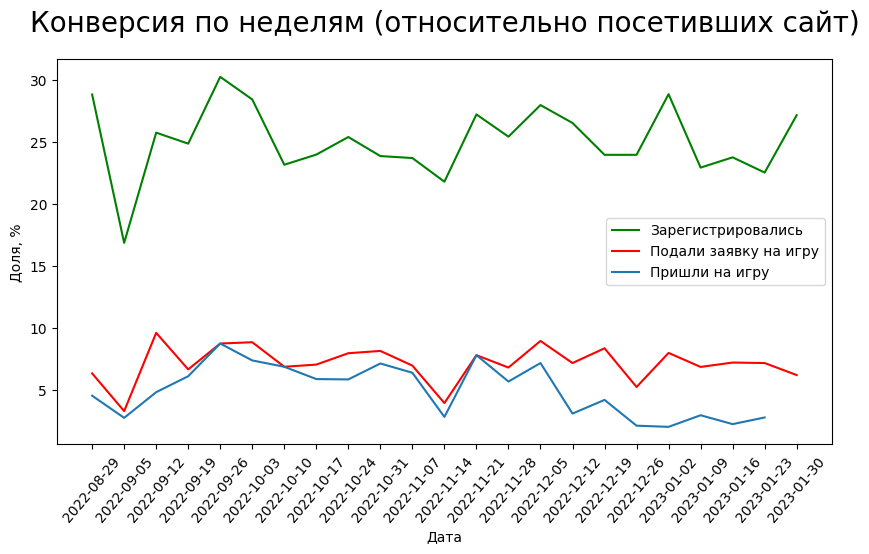

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = weeks_all_data['weeks']
ax.plot(dates, percent_registr, label='Зарегистрировались', color = "green")
ax.plot(dates, percent_applic, label='Подали заявку на игру', color = "red")
ax.plot(dates, percent_visit_game, label='Пришли на игру')
ax.legend()
plt.title('Конверсия по неделям (относительно посетивших сайт)', fontsize=20, pad=20)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

Для дальнейшего изображения на графике необходимо посчитать конверсии относительно предыдущего этапа

In [ ]:
percent_registr = weeks_all_data["registrations"]/weeks_all_data["views"]*100
percent_applic = weeks_all_data["applications"]/weeks_all_data["registrations"]*100
percent_visit_game = weeks_all_data["games_visited"]/weeks_all_data["applications"]*100

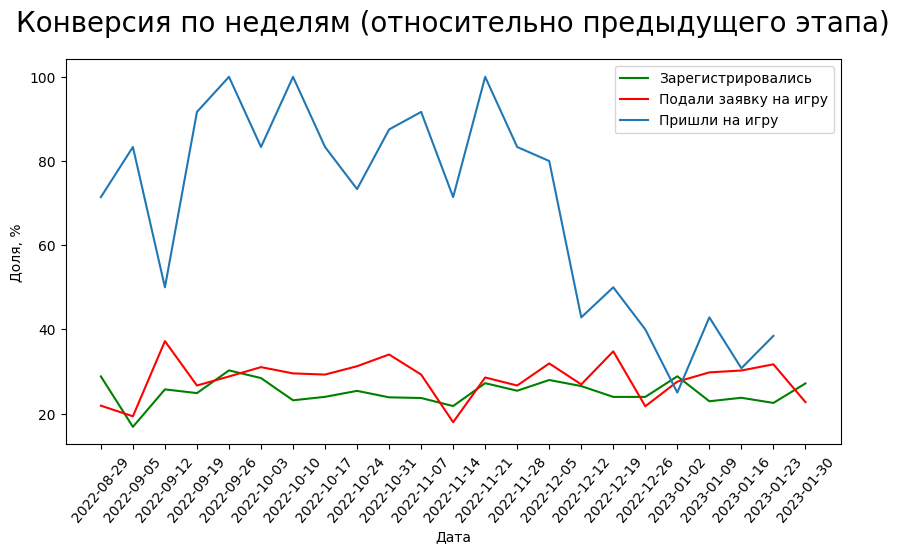

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = weeks_all_data['weeks']
ax.plot(dates, percent_registr, label='Зарегистрировались', color = "green")
ax.plot(dates, percent_applic, label='Подали заявку на игру', color = "red")
ax.plot(dates, percent_visit_game, label='Пришли на игру')
ax.legend()
plt.title('Конверсия по неделям (относительно предыдущего этапа)', fontsize=20, pad=20)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

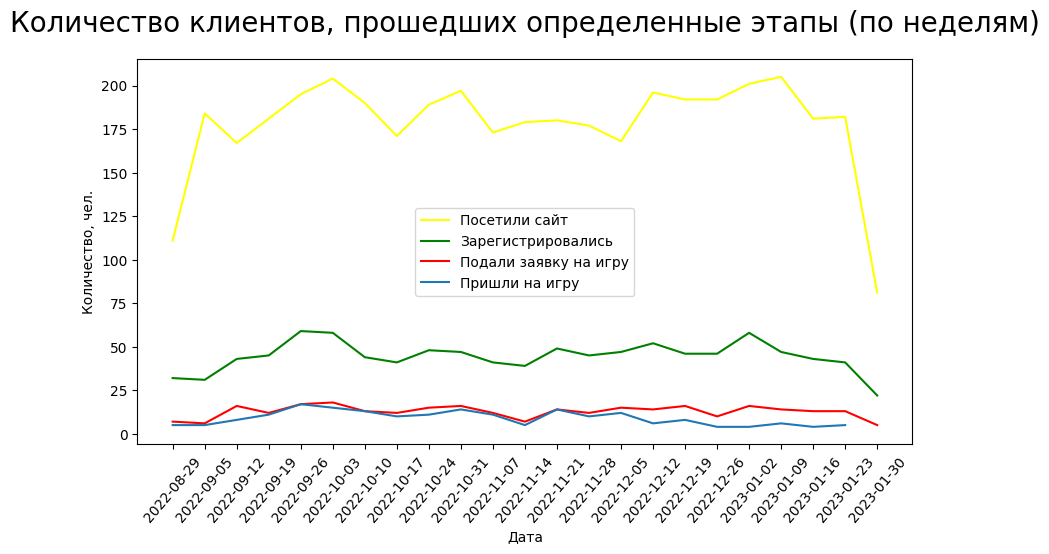

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = weeks_all_data['weeks']
ax.plot(dates, weeks_all_data['views'], label='Посетили сайт', color = "yellow")
ax.plot(dates, weeks_all_data['registrations'], label='Зарегистрировались', color = "green")
ax.plot(dates, weeks_all_data['applications'], label='Подали заявку на игру', color = "red")
ax.plot(dates, weeks_all_data['games_visited'], label='Пришли на игру')
ax.legend()
plt.title('Количество клиентов, прошедших определенные этапы (по неделям)', fontsize=20, pad=20)
plt.ylabel('Количество, чел.')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

# Данные по месяцам

Далее с помощью sql-запросов выберу нужные данные, сгруппированные и отсортированные по месяцам.

Функция DATE_TRUNC округляет дату до первого для месяца.

In [ ]:
columns_123 = pd.read_sql("""SELECT DATE_TRUNC('month', visit_dttm)::date AS months, 
            COUNT(DISTINCT c.client_rk) AS views, 
            COUNT(DISTINCT a.account_rk) AS registrations, 
            COUNT(DISTINCT ap.account_rk) AS applications 
            FROM msu_analytics.client c 
            LEFT JOIN msu_analytics.account a using (client_rk) 
            LEFT JOIN msu_analytics.application ap using (account_rk)
            GROUP BY months
            ORDER BY months""", conn)

column_4 = pd.read_sql("""SELECT DATE_TRUNC('month', client.visit_dttm)::date AS months, 
            COUNT(DISTINCT account_rk) AS games_visited
            FROM msu_analytics.client 
            inner join msu_analytics.account using (client_rk)
            inner join msu_analytics.application using (account_rk ) 
            INNER JOIN msu_analytics.game using (game_rk)
            WHERE game.game_flg = 1
            group by months
            order by months""", conn)

In [ ]:
months_all_data = columns_123.merge(column_4, on="months", how="left")

In [ ]:
months_all_data

,months,views,registrations,applications,games_visited
0,2022-09-01,778,190,51,39.0
1,2022-10-01,843,217,65,56.0
2,2022-11-01,786,200,56,50.0
3,2022-12-01,805,196,57,33.0
4,2023-01-01,852,213,64,20.0
5,2023-02-01,32,8,0,NaN


Для дальнейшего изображения на графике необходимо посчитать конверсии относительно посетивших сайт

In [ ]:
percent_registr = months_all_data["registrations"]/months_all_data["views"]*100
percent_applic = months_all_data["applications"]/months_all_data["views"]*100
percent_visit_game = months_all_data["games_visited"]/months_all_data["views"]*100

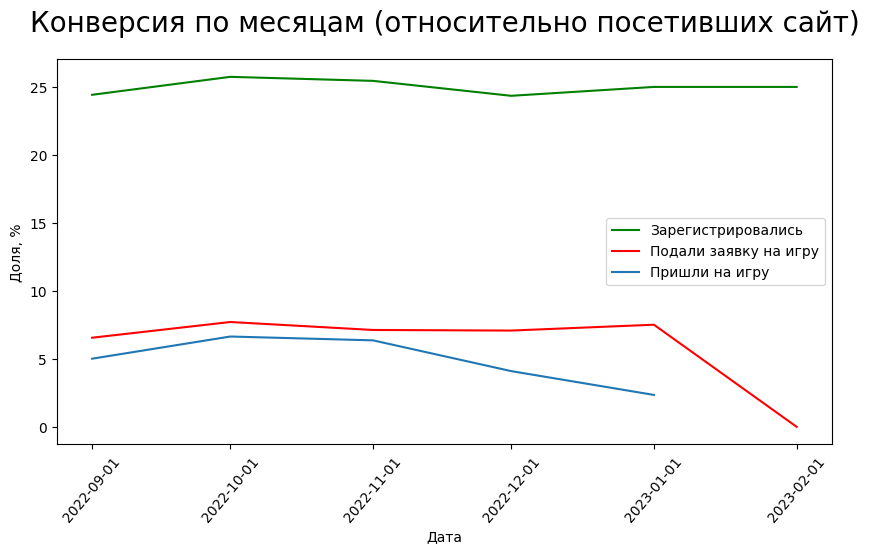

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = months_all_data['months']
ax.plot(dates, percent_registr, label='Зарегистрировались', color = "green")
ax.plot(dates, percent_applic, label='Подали заявку на игру', color = "red")
ax.plot(dates, percent_visit_game, label='Пришли на игру')
ax.legend(loc = "center right")
plt.title('Конверсия по месяцам (относительно посетивших сайт)', fontsize=20, pad=20)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

Для дальнейшего изображения на графике необходимо посчитать конверсии относительно предыдущего этапа

In [ ]:
percent_registr = months_all_data["registrations"]/months_all_data["views"]*100
percent_applic = months_all_data["applications"]/months_all_data["registrations"]*100
percent_visit_game = months_all_data["games_visited"]/months_all_data["applications"]*100

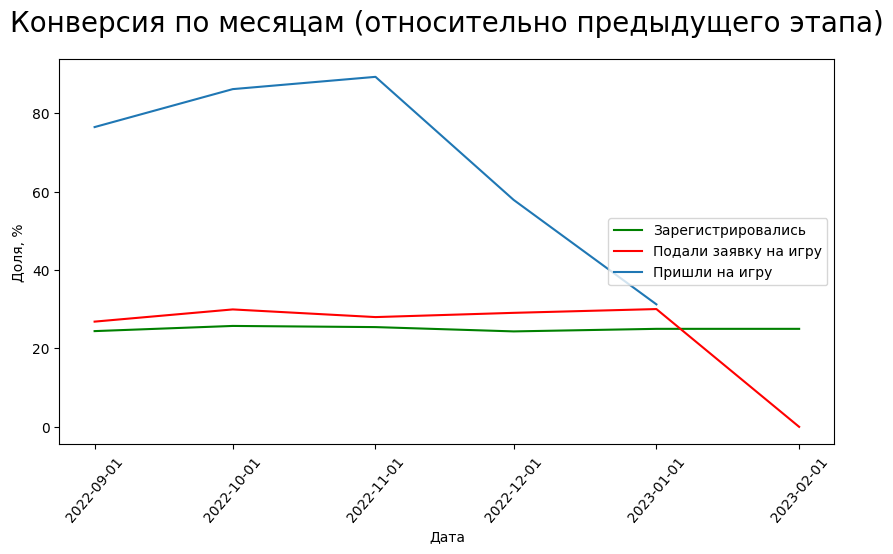

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = months_all_data['months']
ax.plot(dates, percent_registr, label='Зарегистрировались', color = "green")
ax.plot(dates, percent_applic, label='Подали заявку на игру', color = "red")
ax.plot(dates, percent_visit_game, label='Пришли на игру')
ax.legend(loc = "center right")
plt.title('Конверсия по месяцам (относительно предыдущего этапа)', fontsize=20, pad=20)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

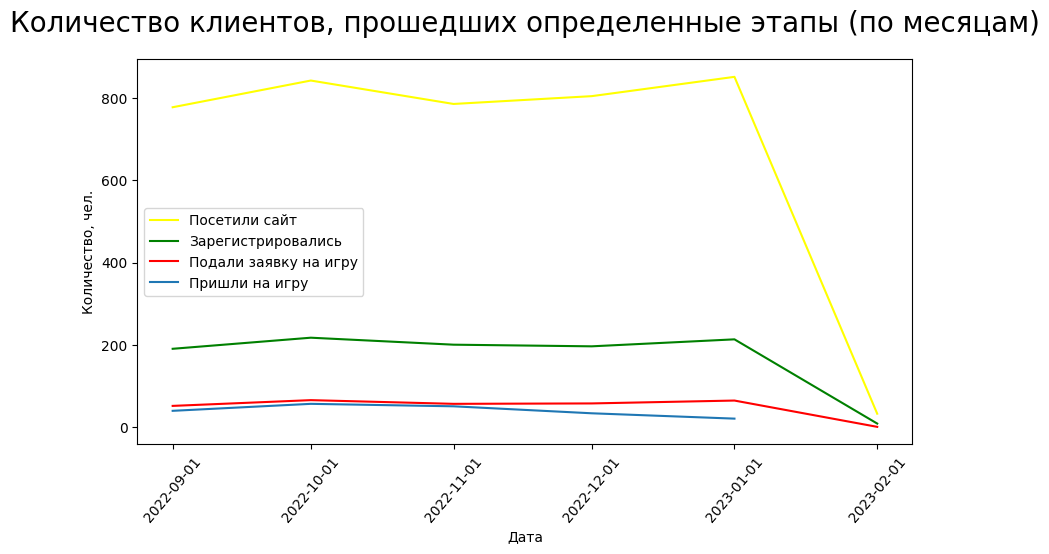

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dates = months_all_data['months']
ax.plot(dates, months_all_data['views'], label='Посетили сайт', color = "yellow")
ax.plot(dates, months_all_data['registrations'], label='Зарегистрировались', color = "green")
ax.plot(dates, months_all_data['applications'], label='Подали заявку на игру', color = "red")
ax.plot(dates, months_all_data['games_visited'], label='Пришли на игру')
ax.legend()
plt.title('Количество клиентов, прошедших определенные этапы (по месяцам)', fontsize=20, pad=20)
plt.ylabel('Количество, чел.')
plt.xlabel('Дата')
plt.xticks(dates, rotation=50)
plt.show()

# Выводы

Воронка
1. По воронке конверсий можно заметить, что до этапа регистрации доходит всего 25% клиентов, посетивших сайт. Это наводит на мысли о проблемах с регистрацией, возможно форма регистрации располагается в неочевидном месте или пристутсвует проблема с сервером, который не может послать код подтверждения на почту/номер телефона. 
2. После регистрации всего 28.6% клиентов подают заявку на игру. Это может быть связано с тем, что люди забывают про квесты и не заходят на сайт повторно. Данную проблему можно решить присылая уведомления о новых квестах на почту клиента (при его согласии, конечно же). 


Графики конверсий и количества клиентов по неделям
1. Графики конверсий и количества клиентов проседают в одинаковых местах: первые недели сентября, первые недели ноября и конец декабря - начало января. Это может быть связано с событиями происходящими в жизнях людей: сентябрь - начало учебного года, нояюрь - период расспродаж и черных пятниц, декабрь-январь - новый год, долгие новогодние праздники, сессия у студентов. Решение - ставить перерывы в расписании квестов, которые приходятся на большие праздники и события.

1. Графики конверсий и количества клиентов падают в январе, несмотря на то, что игр запланировано до марта. Необходимо искать проблему в работе сайта, отображении рекламы квестов. 